In [1]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
from tensorflow.keras.utils import to_categorical
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Grabbing the nominees
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        result: dict, movie name as key, movie information as value
    """
    # remember to use browser header here, or cannot retrieve full data from the website
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    response = requests.get(url, headers = headers)
    html = response.content
    soup = BeautifulSoup(html,'lxml')

    result = {}
    for item in soup.find_all('div', {'class':'result-subgroup subgroup-awardcategory-chron'}):
        try:
            award_title = item.find('div',{'class':'result-subgroup-title'}).find('a',{'class':'nominations-link'}).contents[0]
            if award_title == 'BEST PICTURE':
                sub_groups = item.find_all('div',{'class':'result-details awards-result-actingorsimilar'})
                for sub in sub_groups:
                    sub_result = {}
                    film_title = sub.find('div',{'class':'awards-result-film-title'}).find('a',{'class':'nominations-link'}).contents[0]
                    is_winner = 1
                    statement = sub.find('div',{'class':'awards-result-nominationstatement'}).find('a',{'class':'nominations-link'}).contents[0]           
                    sub_result['film_title'] = film_title
                    sub_result['is_winner'] = is_winner
                    sub_result['statement'] = statement
                    result[film_title] = sub_result
        except Exception:
            pass
    return result

In [3]:
# data of year 2016
best_2016 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:89,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2017
best_2017 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:90,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2018
best_2018 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:91,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

In [4]:
#best_2016

In [5]:
# Load Data
import numpy as np
import pandas as pd
# read from award
df_awards = pd.read_csv('database.csv', skiprows = 1, names=['year','ceremony','award','winner','movieName','filmInfo'])
df_movies = pd.read_csv('movies.csv')
df_credits = pd.read_csv('credits.csv')

In [6]:
#View data
#df_awards #ends at 2015
#print("")
#print(df_credits.head())

In [7]:
# append the data we scrapped to the df_awards
data = []
for k,v in best_2016.items():
    row = []
    row.append(['2016', 89, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])
  
for k,v in best_2017.items():
    row = []
    row.append(['2017', 90, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])

for k,v in best_2018.items():
    row = []
    row.append(['2018', 91, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])

#data #Looks good

In [8]:
# pass the column name to the columns!!! Or there will be a runtime error
df_awards=df_awards.append(pd.DataFrame(data,columns=['year','ceremony','award','winner','movieName','filmInfo']),ignore_index=True)

#df_awards #9990 rows × 6 columns, no duplicate entries

In [9]:
# Data Manipulation - Joining the dataframes
# We start by saving only the movies we have credits info for and merge on the same movie id
# 9990 rows --> 4795 rows

if 'title' in df_credits.columns: 
  df_credits = df_credits.drop('title',axis=1) 
df_credits_movies = df_credits.set_index('movie_id').join(df_movies.set_index('id'))
#df_credits_movies

In [10]:
#df_credits_movies.dtypes

# Reset the data types and get the earliest date of release_date
df_credits_movies['release_date'] = pd.to_datetime(df_credits_movies['release_date'])
#get the earliest release date from the dataset
min_year = min(df_credits_movies['release_date']) #1916-09-04
max_year = max(df_credits_movies['release_date']) #2017-02-03

In [11]:
# Select movies that are only in Outstanding Picture or Best Picture awards category and create a new df, df_picture_awards
df_picture_awards = df_awards.loc[df_awards['award'].isin(['Outstanding Picture','Best Picture'])]
df_picture_awards.reset_index(drop = True, inplace = True)
#332 Rows

# Get only movies that hae been released
df_credits_movies = df_credits_movies.loc[df_credits_movies['status'].isin(['Released'])]

#print("--------------")
#print(df_picture_awards.columns)
#print("--------------")
#print(df_credits_movies.columns)

In [12]:
# Replace all the null value in ‘winner’ column with 1
# df_picture_awards['winner'].isnull().sum()
df_picture_awards['winner'].fillna(1,inplace = True)


In [13]:
# join df_credits_movies and df_picture_awards by movie name

# Change the title in the movie to lower case
import re
movieName = [re.sub(r'[^\w\s]','',x) for x in df_picture_awards['movieName'].str.lower().str.strip().values]
title = [re.sub(r'[^\w\s]','',x) for x in df_credits_movies['title'].str.lower().str.strip().values]

df_picture_awards.loc[:,'movie_title'] = movieName 
df_credits_movies.loc[:,'movie_title'] = title

# check the dataframe, we can see the string in movie_title now is valid
df_picture_awards.movie_title

0                                      the caddo company
1                                                    fox
2                                 paramount famous lasky
3                                    feature productions
4                                                    fox
5                                      metrogoldwynmayer
6                                      metrogoldwynmayer
7                                 paramount famous lasky
8                                     lawrence of arabia
9                                        the longest day
10                       meredith willsons the music man
11                                  mutiny on the bounty
12                                 to kill a mockingbird
13                                       america america
14                                             cleopatra
15                                  how the west was won
16                                   lilies of the field
17                             

In [14]:
# join the two tables, merge the data
df = df_picture_awards.merge(df_credits_movies, left_on='movie_title', right_on='movie_title', how='right')
df = df.reset_index(drop=True)

# @Priya - PROBLEM HERE? WE'RE GETTING JUNK DATA AT THE END OF OUR MASTERLIST.CSV, PRETTY SURE IT'S FOR RECENT YEAR'S DATA
# Maybe single out the junk data 1st and see if we can clean it up? If you sort the csv by release date you can find the junk.

#drop the columns from award table
df.drop('homepage',axis = 1, inplace = True)
df.drop('year',axis = 1, inplace = True)
df.drop('award',axis = 1, inplace = True)
df.drop('movieName',axis = 1, inplace = True)
df.drop('filmInfo',axis = 1, inplace = True)
df.drop('ceremony',axis = 1, inplace = True)
df['winner'].fillna(0,inplace=True) #fill NA with 0
print(df) 

# Print master df to csv
# 4795 rows of movies with appended Best Picture data, that we had crew info for
df.to_csv('masterList.csv', index=False)

      winner                                        movie_title  \
0        1.0                                 lawrence of arabia   
1        1.0                                    the longest day   
2        1.0                              to kill a mockingbird   
3        1.0                                          cleopatra   
4        1.0                                          tom jones   
5        1.0  dr strangelove or how i learned to stop worryi...   
6        1.0                                       mary poppins   
7        1.0                                       my fair lady   
8        1.0                                     doctor zhivago   
9        1.0                                 the sound of music   
10       1.0                                              alfie   
11       1.0                              a man for all seasons   
12       1.0                                    doctor dolittle   
13       1.0                                             olive

In [15]:
df['cast'].dtype

dtype('O')

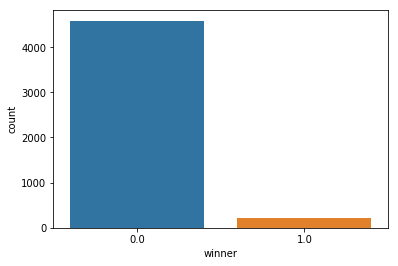

In [16]:
# We will choose the under-sampling by sampling from the 0-labeled data. 
# We need to first get a subset of nominated data, then sample from the non-nominated data, 
# and finally append the sampled data to the subset of nominated data.
sns.countplot(x='winner', data = df)


In [17]:
#Get the number of 0 labeled data, and the number of 1 labeled data
print(len(df.loc[df['winner'] == 0])) #4586
print(len(df.loc[df['winner'] == 1])) #209

4586
209


In [18]:
#balance the data
df_subset_0 = df.loc[df['winner'] == 0]
df_subset_1 = df.loc[df['winner'] == 1]

df_subset_0.drop('winner',axis=1,inplace=True)
df_subset_1.drop('winner',axis=1,inplace=True)

#sample with replacement
df_subset_0 = df_subset_0.sample(400) 
df_subset = pd.concat([df_subset_0,df_subset_1],ignore_index = True)
df_new = df_subset.merge(df_picture_awards, left_on = 'movie_title', right_on = 'movie_title', how = 'left')
df_new = df_new.fillna(0)

In [19]:
print(len(df_new))

609


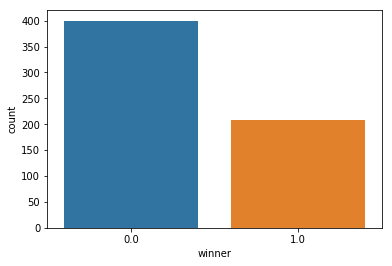

In [20]:
sns.countplot(x='winner', data = df_new)

In [21]:
#check number of null values in the dataset
df_new.isnull().sum()

movie_title             0
cast                    0
crew                    0
budget                  0
genres                  0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
year                    0
ceremony                0
award                   0
winner                  0
movieName               0
filmInfo                0
dtype: int64

In [22]:
#Exploratory Data Analysis

# check the data types and select numeric variables
df_new.dtypes

movie_title                     object
cast                            object
crew                            object
budget                           int64
genres                          object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
title                           object
vote_average                   float64
vote_count                       int64
year                             int64
ceremony                       float64
award                           object
winner                         float64
movieName                

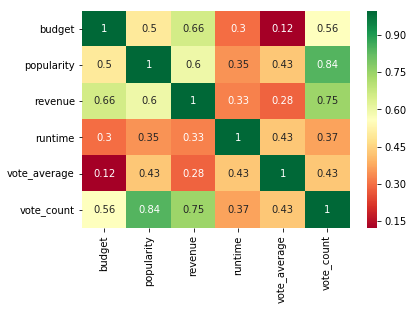

In [23]:
# correlation analysis
g = sns.heatmap(df_new[['budget','popularity','revenue','runtime','vote_average','vote_count']].corr(),cmap='RdYlGn',annot=True)

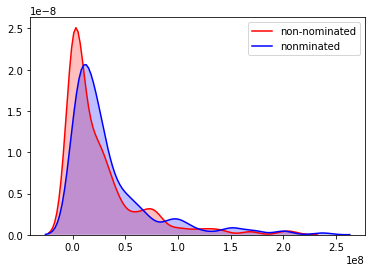

In [24]:
# Density Curve
# budget
budget0 = df_new[df_new['winner'] == 0]['budget']
budget1 = df_new[df_new['winner'] == 1]['budget']

g = sns.kdeplot(budget0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(budget1, legend = True, shade=True, color='b', label = 'nonminated')

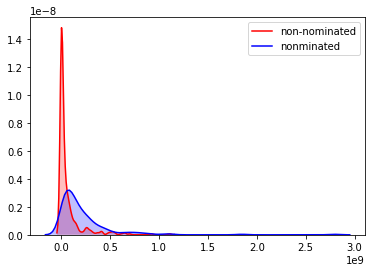

In [25]:
# revenue
# density curve
revenue0 = df_new[df_new['winner'] == 0]['revenue']
revenue1 = df_new[df_new['winner'] == 1]['revenue']

g = sns.kdeplot(revenue0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(revenue1, legend = True, shade=True, color='b', label = 'nonminated')

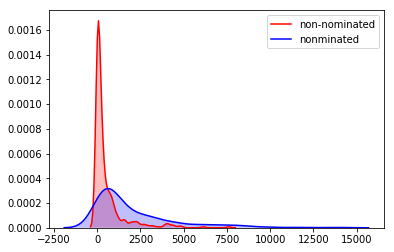

In [26]:
# vote count
vc0 = df_new[df_new['winner'] == 0]['vote_count']
vc1 = df_new[df_new['winner'] == 1]['vote_count']

g = sns.kdeplot(vc0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(vc1, legend = True, shade=True, color='b', label = 'nonminated')

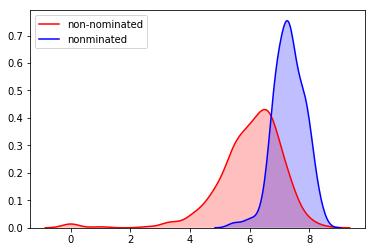

In [27]:
# vote average
va0 = df_new[df_new['winner'] == 0]['vote_average']
va1 = df_new[df_new['winner'] == 1]['vote_average']

g = sns.kdeplot(va0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(va1, legend = True, shade=True, color='b', label = 'nonminated')

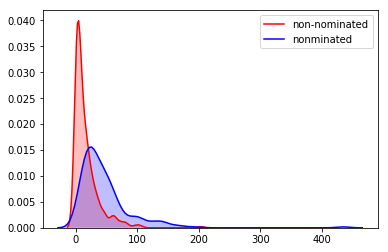

In [28]:
# popularity
popularity0 = df_new[df_new['winner'] == 0]['popularity']
popularity1 = df_new[df_new['winner'] == 1]['popularity']

g = sns.kdeplot(popularity0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(popularity1, legend = True, shade=True, color='b', label = 'nonminated')

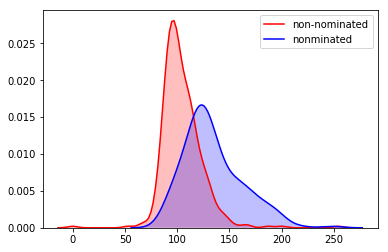

In [29]:
#runtime
runtime0 = df_new[df_new['winner'] == 0]['runtime']
runtime1 = df_new[df_new['winner'] == 1]['runtime']

g = sns.kdeplot(runtime0, legend = True, shade=True, color='r', label = 'non-nominated')
g = sns.kdeplot(runtime1, legend = True, shade=True, color='b', label = 'nonminated')

In [30]:
#genres
#clean the data
genres_name0 = {}
genres_name1 = {}
genres_set = set()
for i in range(len(df_new)):
    genres = json.loads(df_new.loc[i,'genres'])
    for it in genres:
        genres_set.add(it['name'])
        if df_new.loc[i,'winner'] == 0:
            if it['name'] not in genres_name0:
                genres_name0[it['name']] = 1
            else:
                genres_name0[it['name']] += 1
        if df_new.loc[i,'winner'] == 1:
            if it['name'] not in genres_name1:
                genres_name1[it['name']] = 1
            else:
                genres_name1[it['name']] += 1

genres_array0=[]
genres_array1=[]
for g in genres_set:
    if g in genres_name0:
        genres_array0.append(genres_name0[g])
    else:
        genres_array0.append(0)
    if g in genres_name1:
        genres_array1.append(genres_name1[g])
    else:
        genres_array1.append(0)


        
genres_all = []
genres_all.append(np.array(genres_array0)/sum(genres_array0))
genres_all.append(np.array(genres_array1)/sum(genres_array1))

In [31]:
df_genres = pd.DataFrame(genres_all, columns=list(genres_set))
print(df_genres.head())

   Thriller    Horror       War  Animation   Romance    Action    Family  \
0  0.105528  0.034171  0.008040   0.023116  0.072362  0.102513  0.035176   
1  0.078471  0.004024  0.044266   0.004024  0.096579  0.044266  0.020121   

    History   Fantasy     Drama   Foreign  Science Fiction   Mystery  \
0  0.015075  0.028141  0.204020  0.005025         0.046231  0.032161   
1  0.072435  0.028169  0.364185  0.000000         0.018109  0.020121   

    Western    Comedy     Music  Adventure  Documentary     Crime  
0  0.007035  0.146734  0.015075   0.061307      0.00603  0.052261  
1  0.012072  0.064386  0.020121   0.054326      0.00000  0.054326  


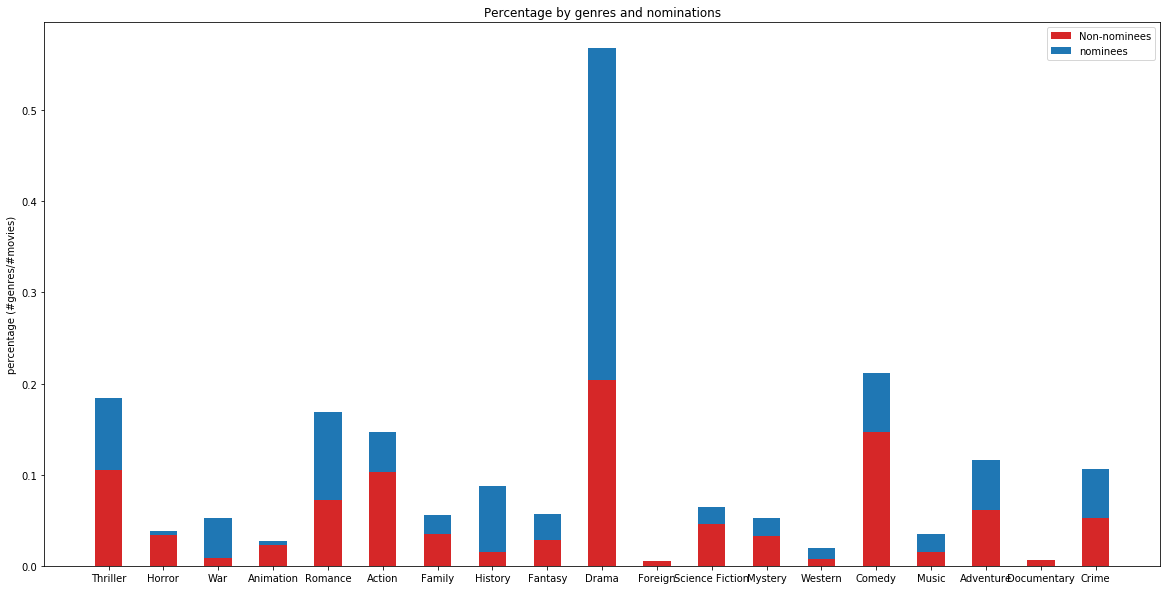

In [32]:
# draw stacked bar chart
N = len(df_genres.columns)
ind = np.arange(N)
width = 0.5

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, df_genres.loc[[0]].values[0], width, color='#d62728')
p2 = plt.bar(ind, df_genres.loc[[1]].values[0], width, bottom=df_genres.loc[[0]].values[0])

plt.ylabel('percentage (#genres/#movies)')
plt.title('Percentage by genres and nominations')
plt.xticks(ind,df_genres.columns)
plt.legend((p1[0],p2[0]),('Non-nominees','nominees'))

In [33]:
# Feature Engineering
# Since many columns such as “crew”, “cast” contain information in json format, we need to extract useful information from the columns and then perform one hot encoding.
# We will transform our dataset into a all numeric matrix so that we can feed the data into our machine learning model.
# To look at the structure of column (eg.”cast”), we can use: df.loc[0,’cast’]
import json
def feature_engineering(column_name, df, json_name):
    """
    Args:
        column_name: the column name in the dataframe that contains a json file that needs to conduct feature engineering on
        df: dataframe that perform feature engineering on
        json_name: name in the json file that we want to extract
    
    Returns: new dataframe after feature engineering
    """
    
    name = {}

    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] not in name:
                name[it[json_name]] = 1
            else:
                name[it[json_name]] += 1
    
    final = {}
    index = 0
    for k,v in name.items():
        if v > 1:
            final[k] = index
            index += 1
    np_item = np.zeros((len(df),len(final)))
    item_dict = {}
    row = 0
    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] in final:
                index = final[it[json_name]]
                np_item[row][index] = 1
        row += 1

    df_item = pd.DataFrame(np_item, columns = list(final.keys()))
    df_output = pd.concat([df,df_item],axis = 1)
    
    return df_output

In [34]:
df2 = feature_engineering("cast", df_new, "name")
df2 = df2.drop('cast', axis = 1) #drop the column after feature engineering

In [35]:
# director
crew_name = {}

for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] not in crew_name:
                crew_name[it['name']] = 1
            else:
                crew_name[it['name']]+=1


# set the appear tims for actors
final_crew = {}
index = 0
for k,v in crew_name.items():
    if v > 0:
        final_crew[k] = index
        index += 1
# print(len(final_crew))

np_crew = np.zeros((len(df2), len(final_crew)))
row = 0
for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] in final_crew:
                index = final_crew[it['name']]
                np_crew[row][index] = 1
    row += 1

df_crew = pd.DataFrame(np_crew, columns = list(final_crew.keys()))
            
df3 = pd.concat([df2, df_crew], axis = 1)
# print(df.shape)

In [36]:
df3=df3.drop(['crew'],axis=1)
#genres
df4 = feature_engineering("genres", df3, "name")
df4 = df4.drop(['genres'], axis = 1)
#keywords
df5 = feature_engineering('keywords', df4, 'name')
df5 = df5.drop(['keywords'], axis = 1)
#production_companies
df6 = feature_engineering('production_companies',df5,'name')
df6 = df6.drop(['production_companies'],axis=1)
#production_countries
df7 = feature_engineering('production_countries',df6,'name')
df7 = df7.drop(['production_countries'],axis=1)
#spoken_languages
df8 = feature_engineering('spoken_languages',df7,'iso_639_1')
df8 = df8.drop(['spoken_languages'],axis=1)
# drop the columns not used
df_clean = df8.drop(["movie_title","original_title","overview","tagline",'title','original_language','status','release_date','movieName','filmInfo','award'],axis=1)

In [37]:
df_clean

,budget,popularity,revenue,runtime,vote_average,vote_count,year,ceremony,winner,Pierce Brosnan,...,gd,hu,pl,mn,ur,tr,vi,hi,fa,ga
0,15000000,45.317278,32556119,108.0,6.0,639,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65000000,20.793026,40002112,100.0,5.1,374,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2.128211,0,94.0,6.8,84,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100,0.394575,0,77.0,5.5,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30000000,22.975918,62616646,91.0,5.5,543,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,55000000,79.922059,192330738,132.0,7.1,2954,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,60000000,23.700759,118338361,88.0,6.4,374,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,18000000,29.487784,261572744,82.0,6.5,1579,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1500000,4.680206,32000,93.0,6.6,183,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,200000000,93.004993,1108561013,143.0,6.9,7604,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Model Training
# split
X = df_clean[df_clean.columns.difference(['winner'])]
# X = StandardScaler().fit_transform(X)
y = df_clean['winner']
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=1/7.0, random_state=0)

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
fit = pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# X_test = pca.transform(X_test)
# pca = PCA(n_components = 3)
# fit = pca.fit_transform(X)
# fit2 = pca.fit(X)
# print("Explained Variance: %s" % pca.explained_variance_ratio_) 
# print(fit)

In [41]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# For small datasets, ‘liblinear’ is a good choice
logisticRegr = LogisticRegression(solver = 'liblinear')
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
# Predict for One Observation
predicted = logisticRegr.predict(X_test)
#print(logisticRegr.predict(X_test))
#print(y_test.index)
# df8['movie_title'][y_test.index]

In [43]:
logisticRegr.score(X_train, y_train)

1.0

In [44]:
logisticRegr.score(X_test, y_test) # 0.8850574712643678

0.8390804597701149

In [45]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
sensitivity = tp/(tp+fn)
print(sensitivity) # 0.84375

0.75


In [46]:
# 3-fold Cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)
sumAccuracy = []
for train,test in skf.split(X,y):
#     logisticRegr.fit(df_clean.iloc[train][], )
    df_train = df_clean.iloc[train]
    df_test = df_clean.iloc[test]
    train_X = df_train[df_clean.columns.difference(['winner'])]
    train_y = df_train['winner']
    test_X = df_test[df_clean.columns.difference(['winner'])]
    test_y = df_test['winner']
    logisticRegr.fit(train_X, train_y)
    sumAccuracy.append(logisticRegr.score(test_X, test_y))
avg = np.mean(sumAccuracy)
print(avg) # 0.7751010491916065
#     print(df_clean.iloc[train,df_clean.columns.difference(['winner'])])

0.7044203646370829
